20180820 basics of language efficiency

# Background

What accounts for the distributional properties we see in natural language? To what extent are these properties related to pressures for languages and communication with language to be efficient? Zipf (1949) argued that languages evolve under competing communicative pressures -- the speaker pressure to be concise and the listener pressure to comprehend. We operationalize these competing costs such that speaker cost is a function of **utterance length** $p(u|m, c)$ below, whereas listener cost is a function of **semantic surprisal** $log_2(p(m|u, c))$ below

Here we present a measure of communicative efficiency `CE` as a balance between these competing speaker and listener pressures. `CE` describes the amount of effort required by a pair of speaker and listener agents to communicate in a given context. A given communicative event involves a set of cooperative agents `A = {S, L}` -- minimally, a speaker `S`, a listener `L`, a language `U` from which the speaker can choose utterances, a set of meanings `M` about which the speaker would like to communicate and listener will try to infer given a context `C` which is a subset of `M`.

`CE` is the average listener surprisal under a speaker language model:

$$CE(A, M, U, C) = \sum_c p(c) \sum_u \sum_m S(u|m, c)log_2(L(m|u, c))$$

We argue that when communication occurs with pragmatic agents (interlocutors who reason about each other in a given context) will always be more efficient than non-pragmatic agents under certain conditions. 

# Theorems

)**Communicative Efficiency** = `CE(A, M, U, C)`

$$A = \{S(\text{peaker}), L(\text{istener})\}$$
$$ $$
$$M = \{H, G, M, HG, HM, GM, HGM\}$$
$$ $$
$$U = \{h, g, m, hg, hm, gm, hgm\}$$
$$ $$
$$C = \wp(M) $$
$$ $$
$$CE_{\text{baseline}}(A, M, U, C) = H(U, M| C) = \sum_c p(c) \sum_u \sum_m p(u, m | c)log_2(p(u | m, c)) = \sum_c p(c) \sum_u \sum_m p(u)p(m)log_2(p(u)p(m))$$
$$CE_{order_0}(A_{\text{baseline}}, M, U, C) = \sum_c p(c) \sum_u \sum_m S_0(u|m, c)log_2(L_0(m|u, c))$$
$$CE_{order_1}(A_{\text{order}_1}, M, U, C) = \sum_c p(c) \sum_u \sum_m S_1(u|m, c)log_2(L_1(m|u, c))$$
$$...$$
$$CE_{order_k}(A_{\text{order}_k}, M, U, C) = \sum_c p(c) \sum_u \sum_m S_k(u|m, c)log_2(L_k(m|u, c))$$

Note that smaller values of CE mean *more* efficient communication.

`Theorem 1`: Systems with "more" pragmatics are more efficient.

$$CE_{\text{baseline}} \ge CE_{\text{order}_0} \ge .. \ge CE_{\text{order}_K}$$

`Theorem 2`: Improvements in efficiency decline as speaker recursion $k \rightarrow \inf$.

$$(CE_{\text{order}_i} - CE_{\text{order}_{i+1}}) > (CE_{\text{order}_{i+1}} - CE_{\text{order}_{i+2}})$$


`Theorem 3`: The difference between $CE_{\text{order}_*} - CE_{\text{order}_0}$ quantifies the pragmatic information $PI$ available in a context. The more items in context the more pragmatic information is "available". As $|C| \rightarrow \inf$, then $PI \rightarrow \inf$ where.
$$PI = CE_{\text{order}_0} - CE_{\text{order}_k}$$

`Theorem 4`: The unconditional entropy of a pragmatic language taken out of context H(U) will be strictly greater thatn H(U|C).

## Connections with optimal cooperative inference (shafto's new paper)
Todo

## Assumptions

Pragmatic efficiency arises when.

    1. Codes in U are ambiguous (can refer to multiple objects).
    2. Contexts include multiple (different) objects.

## Next steps

    * Derive UID from RSA (FYP)
    * Derive CER from RSA (FYP)
    * Derive Law of abbreviation from RSA (Kanwal et al modeling - in progress)
    * Derive H(X) > H(X|C) (Piantadosi, 2012).

In [1]:
from collections import Counter
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm


%matplotlib inline
plt.style.use('seaborn-white')

In [2]:
symbols = ['h', 'g', 'm', 'hg', 'hm', 'gm', 'hgm']
codes = ['h', 'g', 'm', 'hg', 'hm', 'gm', 'hgm']
def create_boolean_matrix(symbols, codes):
    """Note that symbols (meanings) are columns, codes (utterances) are rows."""
    M = []
    for code in codes:
        M.append([1. if code in symbol else 0. for symbol in symbols])
    return np.array(M)

def column_slice(M, select_cols):
    return M[:, select_cols]

def row_normalizer(M):
    """Normalize across columns (sum of each row is 1)"""
    row_totals = np.sum(M, axis=1).astype(float)
    return np.nan_to_num((M.transpose() / row_totals).transpose())

def column_normalizer(M):
    """Normalize across rows (sum of each column is 1)"""
    col_totals = np.sum(M, axis=0).astype(float)
    return np.nan_to_num(M / col_totals)

def rsa_speaker(M, depth=0):
    if depth == 0:
        return column_normalizer(M)
    for _ in range(depth):
        M = column_normalizer(row_normalizer(M)) 
    return M

def rsa_listener(M, depth=0):
    if depth == 0:
        return row_normalizer(M)
    for _ in range(depth):
        M = row_normalizer(column_normalizer(M))
    return M

In [3]:
def J(S, L, rounder=lambda x: x, run_baseline=False):
    """sum_m sum_u p_s(u|m)*log2(p_m|u)"""
    res = 0
    PU = 1 / float(len(S))
    PM = 1 / float(len(S[0, :]))
    for row, _ in enumerate(S):
        for col, _ in enumerate(S[row, :]):
            listener_surprisal = np.log2(L[row][col]) if L[row][col] != 0. else 0.
            listener_surprisal = rounder(listener_surprisal)
            p_speaker = S[row][col]
            if run_baseline:
                res += PU * np.log2(PM) if PM != 0. else 0.
            else:
                res +=  p_speaker * listener_surprisal
    return -res

In [4]:
def to_array(np_arr):
    return [v for v in np_arr]

In [5]:
M = create_boolean_matrix(symbols, codes)

In [24]:
max_depth = 50
n_sims = 100
res = []
seen_contexts = set()
for i in tqdm.tqdm(range(n_sims)):
    context_size = np.random.choice(range(1, len(symbols)), 1)[0]
    slice_ = to_array(set(np.random.choice(range(len(symbols)), context_size, replace=False)))
    context_str = ''.join(['{}']*len(slice_))
    context_str = context_str.format(*slice_)

    # Check if we've seen this context before
    while context_str in seen_contexts:
        context_size = np.random.choice(range(1, len(symbols)), 1)[0]
        slice_ = to_array(np.random.choice(range(len(symbols)), context_size, replace=False))
        context_str = ''.join(['{}']*len(slice_))
        context_str = context_str.format(*slice_)

    
    # Create boolean matrix
    M_ =  column_slice(M, slice_)
    speakers = []
    listeners = []
    curr_data = []
    for d in range(-1, max_depth):
        S = rsa_speaker(M_, d)
        L = rsa_listener(M_, d)
        # Note of d == 0 we use baseline model.
        if d == -1:
            curr_data.append(('J{}'.format(d), J(S, L, run_baseline=True)))
        else:
            curr_data.append(('J{}'.format(d), J(S, L)))
    curr_data.extend([("context_size", context_size), ("context", context_str)])
    res.append({k:v for k, v in curr_data})
    seen_contexts.add(context_str)
    
df_res = pd.DataFrame(res)

100%|██████████| 100/100 [00:12<00:00,  7.79it/s]


In [25]:
# df_res_melted = df_res \
#     .melt(id_vars=['context'], value_vars=['J{}'.format(range(d) for d in range(max_depth))])
model_nums = range(max_depth)    
models = ['J{}'.format(d) for d in model_nums]
max_model = models[-1]
df_res = df_res.sort_values(by=max_model)

## `Theorem 1`: Systems with "more" pragmatics are more efficient.

Text(0.5,1,'Theorem 1: CE(k order) > CE(k-1 order)')

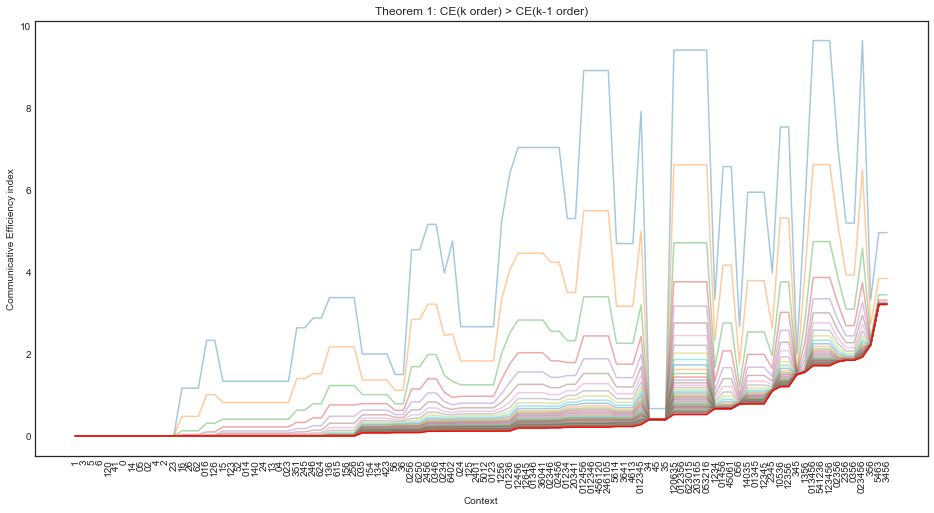

In [26]:
plt.figure(figsize=(16,8))
plt.xticks(rotation=90)
for model in models:
    if model == max_model:
        plt.plot(df_res['context'].values, df_res[model].values, alpha=0.95, c='red', markersize=20)
    else:
        plt.plot(df_res['context'].values, df_res[model].values, alpha=0.4, markersize=12)
plt.ylabel("Communicative Efficiency index")
plt.xlabel("Context")
plt.title("Theorem 1: CE(k order) > CE(k-1 order)")

In [27]:
df_res_melted = df_res \
    .melt(id_vars=['context'], value_vars=models)

In [28]:
def diff(x):
    min_ = min(x['value'])
    x['diff'] = x['value'] - min_
    max_ = max(x['value'])
    x['PI'] = max_-min_
    return x 

df_res_melted = df_res_melted \
    .groupby(['context']) \
    .apply(lambda x: diff(x))

## `Theorem 2`: Improvements in efficiency decline as speaker recursion $k \rightarrow \inf$.

Declines explonentially?

Text(0.5,1,'Theorem 2: (CE(k order) - CE(k-1 order)) > (CE(k+1 order) - CE(k order))')

<Figure size 432x288 with 0 Axes>

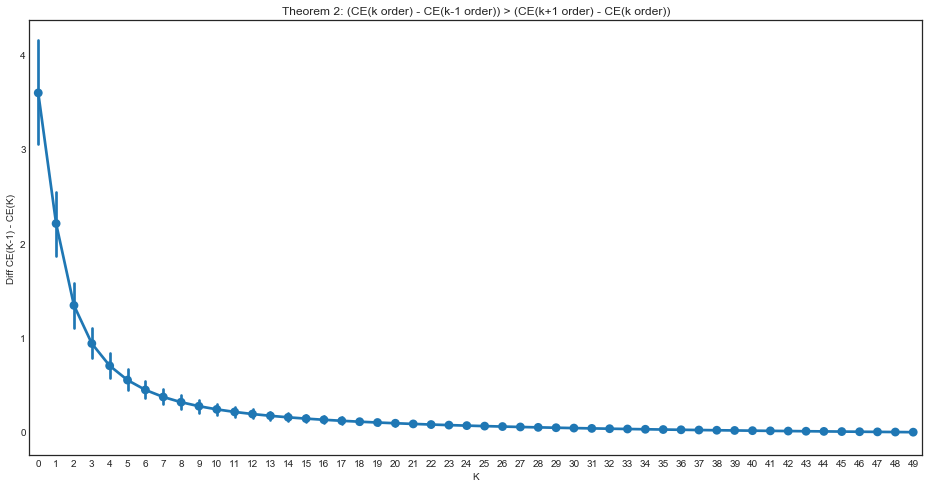

In [48]:
plt.clf()
plt.figure(figsize=(16,8))
color_map = {model: idx for idx, model  in enumerate(models)}
df_res_melted['color'] = df_res_melted['variable'].apply(lambda x: color_map[x])
df_res_melted['k'] = df_res_melted['variable'].apply(lambda x: int(''.join(list(x)[1:])))
sns.pointplot(df_res_melted['k'].values, df_res_melted['diff'].values, 
            alpha=0.3,
            s=200,
            edgecolor='w')
plt.ylabel('Diff CE(K-1) - CE(K)')
plt.xlabel('K')
plt.title("Theorem 2: (CE(k order) - CE(k-1 order)) > (CE(k+1 order) - CE(k order))")

Text(0.5,1,'Theorem 2: (CE(k order) - CE(k-1 order)) > (CE(k+1 order) - CE(k order))')

<Figure size 432x288 with 0 Axes>

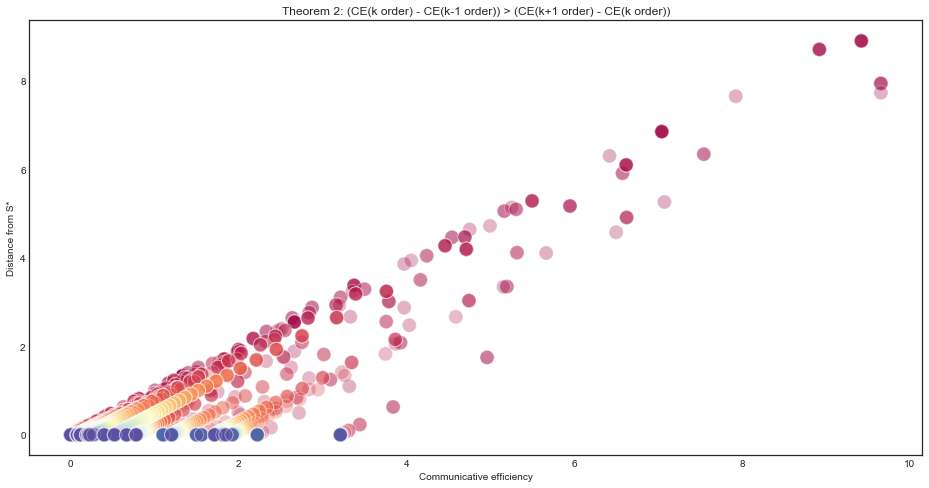

In [49]:
plt.clf()
plt.figure(figsize=(16,8))
color_map = {model: idx for idx, model  in enumerate(models)}
df_res_melted['color'] = df_res_melted['variable'].apply(lambda x: color_map[x])
plt.scatter(df_res_melted['value'].values, 
            df_res_melted['diff'].values, 
            alpha=0.3,
            c=df_res_melted['color'].values, 
            s=200,
            edgecolor='w',
            cmap=plt.cm.Spectral)
plt.ylabel('Distance from S*')
plt.xlabel('Communicative efficiency')
plt.title("Theorem 2: (CE(k order) - CE(k-1 order)) > (CE(k+1 order) - CE(k order))")

## `Theorem 3`: the more items in context the more pragmatic information is "available". As $|C| \rightarrow \inf$, then $PI \rightarrow \inf$

In [51]:
df_res_melted_1 = df_res_melted.loc[:, ['context', 'PI']].drop_duplicates()

Text(0.5,1,'Theorem 3: PI scales with |C|')

<Figure size 432x288 with 0 Axes>

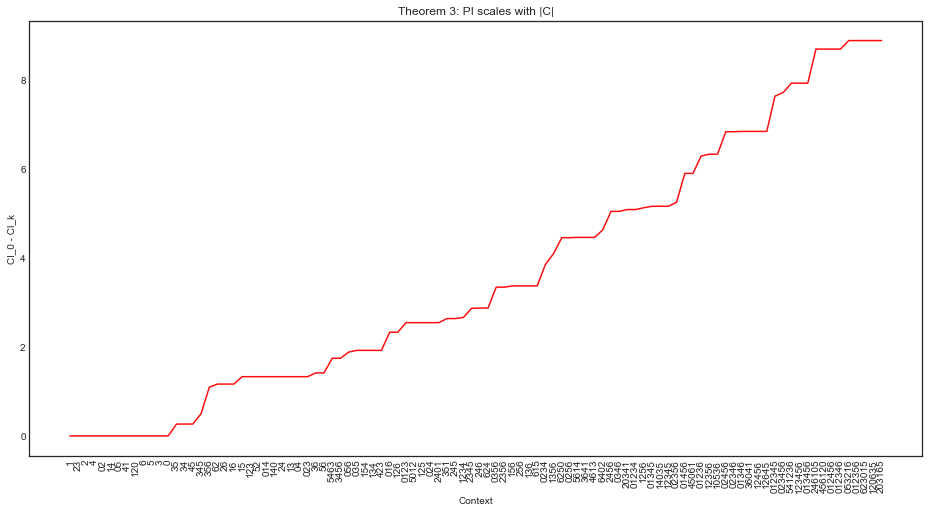

In [52]:
plt.clf()
plt.figure(figsize=(16,8))
plt.xticks(rotation=90)
df_res_melted_1 = df_res_melted_1.sort_values(['PI'])
plt.plot(df_res_melted_1['context'].values, df_res_melted_1['PI'].values, alpha=0.95, c='red', markersize=20)
plt.ylabel("CI_0 - CI_k")
plt.xlabel("Context")
plt.title("Theorem 3: PI scales with |C|")

In [53]:
df_res_melted_1['context_size'] = df_res_melted_1['context'].apply(lambda x: len(list(x)))

In [54]:
df_res_melted_summary = df_res_melted_1 \
    .groupby(by=['context_size']) \
    .describe() \
    .reset_index()

Text(0.5,1,'Theorem 3: PI scales with |C|')

<Figure size 432x288 with 0 Axes>

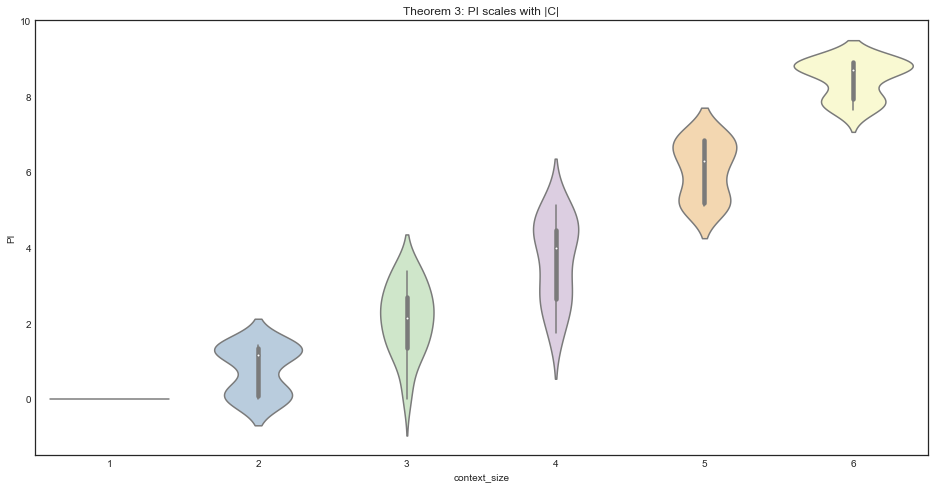

In [55]:
plt.clf()
plt.figure(figsize=(16,8))
sns.violinplot(x='context_size', y='PI', ci=0.975, palette="Pastel1", data=df_res_melted_1)
plt.title("Theorem 3: PI scales with |C|")


## Webpppl 20180821
```
var descriptors = ['h', 'g', 'm', 'hg', 'hm', 'gm', 'ghm']
var objects = ['h', 'g', 'm', 'hg', 'hm', 'gm', 'ghm']
var context1 = {
  '1': 'h', 
  '2': 'hg', 
  '3': 'hgm'
}

var context2 = {
  '1': 'hg', 
  '2': 'hg', 
  '3': 'hgm'
}
var context0 = {
  '1':'h', 
  '2':'g', 
  '3':'m', 
  '4':'hg', 
  '5':'hm', 
  '6':'gm',
  '7':'ghm'
}

var constructContext = function(idxs) {
  var objs = map(function(idx) {return objects[idx]}, idxs)
  return objs
}

var literalSemantics = function(descriptor, obj) {
  var tokens = descriptor.split('')
  return all(function(ch) {return obj.includes(ch)}, tokens)
}

var cost = function(description) {
  return description.length
}


var alpha = 1.
var L0 = function(descriptor, context) {
  Infer({
    model() {
      var obj = context[uniformDraw(Object.keys(context))]
      var meaning = literalSemantics(descriptor, obj)
      factor(meaning ? 0 : -Infinity)
      return obj
    }
  })
}

var S0 = function(obj_idx, context) {
  Infer({
    model() {
      var descriptor = uniformDraw(descriptors)
      var L = L0(descriptor, context)
      factor(L.score(context[obj_idx]))
      return descriptor
    }
  })
}

var S1 = function(obj_idx, context) {
  Infer({
    model() {
      var descriptor = uniformDraw(descriptors)
      var L = L0(descriptor, context)
      factor(alpha * (L.score(context[obj_idx])-descriptor.length))
      return descriptor
    }
  })
}

var S2 = function(obj_idx, context) {
  Infer({
    model() {
      var descriptor = uniformDraw(descriptors)
      var L = L1(descriptor, context)
      factor(alpha * (L.score(context[obj_idx])-descriptor.length))
      return descriptor
    }
  })
}

var L1 = function(descriptor, context) {
  Infer({
    model() {
      var obj_idx = uniformDraw(Object.keys(context))
      var S = S1(obj_idx, context)
      factor(S.score(descriptor))
      return context[obj_idx]
    }
  })
}

var L2 = function(descriptor, context) {
  Infer({
    model() {
      var obj_idx = uniformDraw(Object.keys(context))
      var S = S2(obj_idx, context)
      factor(S.score(descriptor))
      return context[obj_idx]
    }
  })
}

viz.table(L0('h', context1))
viz.table(S0('3', context1))

viz.table(L1('h', context1))
viz.table(S1('3', context1))

viz.table(L2('h', context1))
viz.table(S2('3', context1))


```